# [aftershoq]: A guide to QCL optimization

Author: Martin Franckie, Sept. 2018

This guide will show you how to:

- Set up optimization environment
- Optimize a model function with different methods
- Optimize quantum cascade structures with a model interface

This guide uses the information algorithm with parallel trials (IAPT) from Strongin and Sergeyev, “Global Optimization with Non-Convex Constraints: Sequential and Parallel Algorithms”, Kluwer Academic Publishers, London (2000), as well as a method based on Gaussian process regression (GP).

Setting up and defining test function:

In [1]:
from aftershoq.interface import NDtestfunc
from aftershoq.numerics import Paraopt, Gaussopt
from aftershoq.utils import HilbertUtil
from hilbert_curve.hilbert import HilbertCurve
import numpy as np
import random as rm
from matplotlib import pyplot as pl

# Number of dimensions:
ND = 2

# generate the Hilbert curve:
p = 7
hc = HilbertCurve( p, ND )
hutil = HilbertUtil( hc )

Now we define the optimization scheme to be used (Paraopt implements IAPT, Guassopt implements Gaussian process regression):

In [2]:
scheme = 1 # 0= IAPT, 1= GP

tol, its, Nproc, r = 0.0005, 100, 1, 0.3

if scheme==0:
    # Creating the optimization object for IAPT:
    opt = Paraopt(tolerance=tol*hutil.imax, maxiter=its, 
                  procmax=Nproc, r=r)
elif scheme==1:
    # Creating the optimization object for GP:
    opt = Gaussopt(tolerance=tol*hutil.imax, maxiter=its, procmax=Nproc,  
                   sigma = 10, l = hutil.imax*0.01, sigma_noise=0.05,
               padding=1000, sigma_noise_max = 5)

The following code blocks can be evaluated separately.
The first one tests the algorithms for a model function (fast check for different schemes and dimensions), the second one uses an actual QCL simulation model to optimize a QCL.

## Test function minimum search

old theta =  [10, 1365.25, 0.05] [ 29.92006053]
Optimization terminated successfully.
         Current function value: 12.851493
         Iterations: 43
         Function evaluations: 111
         Gradient evaluations: 111
new theta =  [  1.25752253e+00   1.44661131e+03   1.42144049e-01] [ 12.85149327]
[array([ 5498.95437567])]
old theta =  [10, 1365.25, 0.05] [ 29.92006053]
Optimization terminated successfully.
         Current function value: 12.851493
         Iterations: 43
         Function evaluations: 111
         Gradient evaluations: 111
new theta =  [  1.25752253e+00   1.44661131e+03   1.42144049e-01] [ 12.85149327]
[array([ 5498.95437567])]
Converged:  0
old theta =  [10, 1260.2307692307693, 0.05] [ 34.52868658]
         Current function value: 11.712311
         Iterations: 84
         Function evaluations: 227
         Gradient evaluations: 215
new theta =  [  1.39258500e+00   4.90037608e+03  -3.37210917e-01] [ 11.71231107]
[array([ 7566.62766114])]
Converged:  0
old theta

         Current function value: 13.252879
         Iterations: 100
         Function evaluations: 244
         Gradient evaluations: 244
new theta =  [  1.25068175e+00   2.52912065e+03  -2.15533822e-01] [ 13.25287881]
[array([ 5587.26600879])]
Converged:  0
old theta =  [10, 481.85294117647061, 0.05] [ 84.29786139]
         Current function value: 14.445212
         Iterations: 100
         Function evaluations: 253
         Gradient evaluations: 253
new theta =  [ -1.11527630e+00   2.00260493e+03   2.11301643e-01] [ 14.44521218]
[array([ 5534.27902892])]
Converged:  0
old theta =  [10, 468.08571428571429, 0.05] [ 84.45493471]
         Current function value: 14.094115
         Iterations: 84
         Function evaluations: 250
         Gradient evaluations: 238
new theta =  [  1.22072723e+00   2.70217991e+03   2.30066044e-01] [ 14.09411536]
[array([ 16382.14152053])]
Converged:  0
old theta =  [10, 455.08333333333331, 0.05] [ 83.3866938]
         Current function value: 29.903930
    

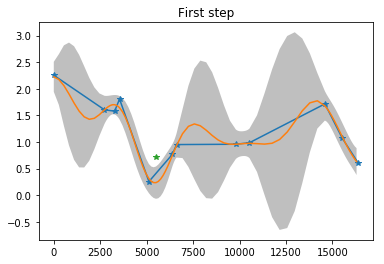

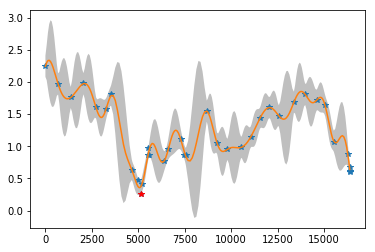

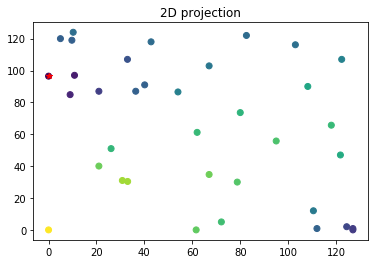

In [3]:
# Model function

# define the model interface. This is a simple test.
model = NDtestfunc(ND)

# initial points are random along the Hilbert curve
N0 = 10
x0 = []
y0 = []
x0.append(0.)
[x0.append(rm.random()*hutil.imax) for _ in range(N0)]
x0.append(hutil.imax)

x0 = np.sort(x0)

# To retreive coordinates, we have to scale by 2^p. opt will minimize,
# hence we append the negative of the merit function:
[y0.append(-model.getMerit(hutil.interp_coords_from_dist(xx)/2.**hutil.p)) 
 for xx in x0]

opt.addpoints(x0, y0)

newx = opt.nextstep()
if newx == -1:
    print("Failed to find new x-points from given input!")
    exit(1)
print(newx)
newy = []
[newy.append(-model.getMerit(hutil.interp_coords_from_dist(xx))) for xx in newx]

if scheme==1:
    xt1 = opt.xt
    mean1 = np.squeeze(opt.mean)
    var1 = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )


conv = opt.minimize_parameters(model, hutil)

print ("Convergence: " + str(conv) + " after " + str(opt.iter) + " iterations.")

optpointHC = opt.getbest()
optpointND = hutil.interp_coords_from_dist(optpointHC[0])



points = []
xND = []
yND = []
for x in opt.x:
    point = hutil.interp_coords_from_dist(x)
    xND.append(point[0])
    yND.append(point[1])
    points.append(point)
    
# plotting the results:

pl.figure(1)
pl.plot(x0, y0, '-*')

if scheme==1:
    pl.plot(xt1, mean1)
    pl.fill_between(np.squeeze(xt1), mean1-np.squeeze(2*np.sqrt(var1)),
                    mean1+np.squeeze(2*np.sqrt(var1)), 
                    facecolor = "grey", alpha=0.5)
    
pl.plot(newx, newy, '*')
pl.title("First step")

pl.figure(2)
if scheme==0:
    pl.plot(opt.x, opt.y, '-*')
elif scheme==1:
    pl.plot(opt.x, opt.y, '*')
    
pl.plot(opt.getbest()[0], opt.getbest()[1], 'r*')

if scheme==1:
    mean = np.squeeze(opt.mean)
    var = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )
    pl.plot(opt.xt, mean)
    pl.fill_between(np.squeeze(opt.xt), mean-np.squeeze(2*np.sqrt(var)),
                    mean+np.squeeze(2*np.sqrt(var)), 
                    facecolor = "grey", alpha=0.5)

pl.figure(3)

pl.scatter(xND, yND, c=np.squeeze(opt.y))
pl.title("2D projection")
pl.hold
pl.plot(optpointND[0], optpointND[1], 'r*')

pl.show()



## Optimizing a QC structure with a simulation model

dopindex = []
Dim = 6, p = 7, imax = 4398046511103, pmax = 127
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...


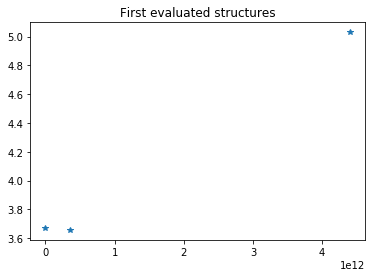

old theta =  [10, 1466015503701.0, 0.05] [ 8.41165271]
Optimization terminated successfully.
         Current function value: 6.635559
         Iterations: 7
         Function evaluations: 17
         Gradient evaluations: 17
new theta =  [  3.57761824e+00   1.46601550e+12  -8.52165218e-06] [ 6.63555868]
old theta =  [10, 1099511627775.75, 0.05] [ 11.89580441]
Optimization terminated successfully.
         Current function value: 9.459976
         Iterations: 10
         Function evaluations: 18
         Gradient evaluations: 18
new theta =  [  3.50867701e+00   1.09951163e+12   3.84621813e-05] [ 9.45997614]
old theta =  [10, 879609302220.59998, 0.05] [ 14.88396095]
Optimization terminated successfully.
         Current function value: 11.733900
         Iterations: 7
         Function evaluations: 17
         Gradient evaluations: 17
new theta =  [  3.42582184e+00   8.79609302e+11   5.79091197e-05] [ 11.73390033]
old theta =  [10, 733007751850.5, 0.05] [ 18.41329577]
Optimization termi

old theta =  [10, 231476132163.3158, 0.05] [ 255.52932346]
Optimization terminated successfully.
         Current function value: 46.980815
         Iterations: 11
         Function evaluations: 25
         Gradient evaluations: 25
new theta =  [  3.34580440e+00   2.31476132e+11   1.26022698e+00] [ 46.98081481]
old theta =  [10, 219902325555.14999, 0.05] [ 655.55030085]
Optimization terminated successfully.
         Current function value: 49.436411
         Iterations: 9
         Function evaluations: 22
         Gradient evaluations: 22
new theta =  [  3.34064651e+00   2.19902326e+11   1.26118281e+00] [ 49.43641143]
old theta =  [10, 209430786243.0, 0.05] [ 719.51326229]
Optimization terminated successfully.
         Current function value: 51.950423
         Iterations: 10
         Function evaluations: 23
         Gradient evaluations: 23
new theta =  [  3.38336508e+00   2.09430786e+11   1.27028539e+00] [ 51.95042331]
old theta =  [10, 199911205050.13635, 0.05] [ 570.35161331]
Opti

old theta =  [10, 118866121921.7027, 0.05] [ 1719.80243019]
Optimization terminated successfully.
         Current function value: 91.146391
         Iterations: 11
         Function evaluations: 26
         Gradient evaluations: 26
new theta =  [  3.29590838e+00   1.18866122e+11   1.31680648e+00] [ 91.14639067]
Converged for x, ix, u(x) =  [  1.48407643e+12] 110 -1.64647465746
Converged!
1
old theta =  [10, 115738066081.6579, 0.05] [ 1606.00276132]
Optimization terminated successfully.
         Current function value: 93.110113
         Iterations: 11
         Function evaluations: 29
         Gradient evaluations: 29
new theta =  [  3.30982977e+00   1.15738066e+11   1.28085198e+00] [ 93.11011289]
Converged for x, ix, u(x) =  [  1.48407643e+12] 110 -1.77262667091
Converged!
1
old theta =  [10, 112770423361.61539, 0.05] [ 1517.52041434]
Optimization terminated successfully.
         Current function value: 94.934219
         Iterations: 9
         Function evaluations: 24
         Grad

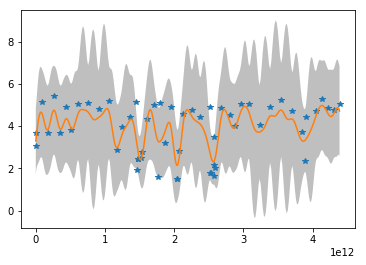

In [4]:
from aftershoq.interface import Isewlab
from aftershoq.qcls import EV2416
from aftershoq.structure import Sgenerator
from aftershoq.numerics.runplatf import Local
from aftershoq.materials import GaAs
import aftershoq.utils.systemutil as su

s = EV2416()

dw = []
[dw.append(l.width*0.10) for l in s.layers]

sg = Sgenerator(s, dw)
# keep binpath = "" if binary is in main path
binpath = ""
su.mkdir("demo/")
wdpath = su.abspath("demo/")
pltfm = Local()

Ns = 3
coords = sg.genRanHilbertStructs(Ns, p)

# Choose your model:
# model = Inegf(binpath, pltfm, GaAs() )
# model = Isewself(binpath, pltfm, [GaAs(), AlGaAs(x=0.15)])
model = Isewlab(binpath + "sewlab", pltfm, GaAs())

model.numpar["efield0"] = -0.150
model.absorption_params["min-photon-energy"] = 0.010
model.absorption_params["max-photon-energy"] = 0.020

model.runStructures(sg.structures, wdpath)
model.waitforproc(3, "Simulation is running...")
model.gatherResults(sg.structures, wdpath)
opt.x = []
opt.y = []
x0, y0 = opt.addEvaldPoints(model, sg, wdpath, coords)

pl.figure(6)
pl.plot(x0, y0, '*')
pl.title("First evaluated structures")
pl.show()

conv = opt.minimize(model, sg, wdpath)

print( "Convergence: " + str(conv) )

pl.figure(7)
pl.plot(opt.x,opt.y,'*')
if scheme==1:
    mean = np.squeeze(opt.mean)
    var = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )
    pl.plot(opt.xt, mean)
    pl.fill_between(np.squeeze(opt.xt), mean-np.squeeze(2*np.sqrt(var)),
                    mean+np.squeeze(2*np.sqrt(var)), 
                    facecolor = "grey", alpha=0.5)
pl.show()